In [49]:
using Plots
using Zygote
using Printf
using JLD2
using DiffEqFlux
using Flux
using OrdinaryDiffEq
using DiffEqSensitivity
using BSON: @load

include("src/utils/graphic_tools.jl")
include("src/neural_ode/models.jl")
include("src/utils/processing_tools.jl")
include("src/utils/generators.jl")
include("src/examples/burgers/analysis.jl")
include("src/examples/burgers/burgers_direct.jl")

Main.BurgersDirect

---
# Hyper-parameter tuning

## Architecture - FNN

In [3]:
ho_nonoise = JLD2.load("./src/examples/burgers/models/feedforward_256/hyperopt_result_fnn_256_nonoise.jld2")["ho"];
ho_05noise = JLD2.load("./src/examples/burgers/models/feedforward_256/hyperopt_result_fnn_256_05noise.jld2")["ho"];
ho_15noise = JLD2.load("./src/examples/burgers/models/feedforward_256/hyperopt_result_fnn_256_15noise.jld2")["ho"];

┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#734###hyperopt_objective#369#4} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.LHSampler does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#1566###hyperopt_objective#387#18} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.LHSampler does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#1144###hyperopt_objective#378#11} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/p

In [4]:
function get_d_train(ho)
    d = Dict([]);
    x =  [16, 24, 32, 40, 48, 56];
    y = [1, 2, 3, 4];

    for a in x
        for b in y
            d[(b, a)] = 1.;
        end
    end

    for (i, tupl) in enumerate(ho.history)
        d[tupl[1]] = ho.results[i];
    end
    
    return d
end

get_d_train (generic function with 1 method)

In [5]:
using BSON

function get_d_val(ho, dataset, filepath)
    d = Dict([]);
    x =  [16, 24, 32, 40, 48, 56];
    y = [1, 2, 3, 4];
    
    
    (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.75, false, false);
    print(val_loader.nobs)
    function val_loss(K, p, x, y, t)
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), abstol=1e-9, reltol=1e-9, saveat=t);
        ŷ = prob_neuralode(x, p);
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
        return l;
    end
    
    function evalcb(K, p, val_loader)
        lval = 0;
        for (x, y, t) in val_loader
            lval += val_loss(K, p, x, y, t[1]);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        return lval
    end
    

    for k in y
        for l in x
            d[(k, l)] = 1.;
        end
    end
    
    for (i, tupl) in enumerate(ho.history)
        filename = filepath * string(i) * ".bson"
        BSON.@load filename K p;
        l = evalcb(K, p, val_loader);
        d[tupl[1]] = l;
    end
    
    return d
end

get_d_val (generic function with 1 method)

In [6]:
x =  [16, 24, 32, 40, 48, 56];
y = [1, 2, 3, 4];

d_nonoise = get_d_train(ho_nonoise);
d_05noise = get_d_train(ho_05noise);
d_15noise = get_d_train(ho_15noise);

function f(x, y, d)
    return d[(y, x)];
end

f (generic function with 1 method)

In [12]:
# dataset = JLD2.load("./src/examples/burgers/dataset/high_dim_256_set_j173.jld2")["training_set"];
dataset = JLD2.load("./src/examples/burgers/dataset/viscous_burgers_high_dim_m10_256_j173.jld2")["training_set"];

In [7]:
# dataset_1k = JLD2.load("./src/examples/burgers/dataset/high_dim_1k_set_j173.jld2")["training_set"];

In [13]:
d_val_nonoise = get_d_val(ho_nonoise, dataset, "./src/examples/burgers/models/feedforward_256/tuning_burgers_nonoise_reg_iter_");

64

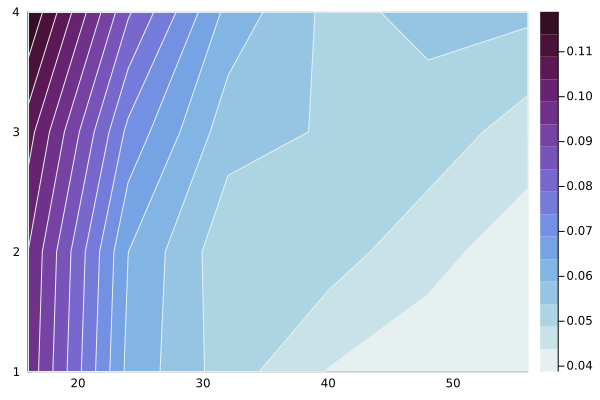

In [43]:
plot(contourf(x, y, (x, y) -> f(x, y, d_nonoise), c=:dense), dpi=600)

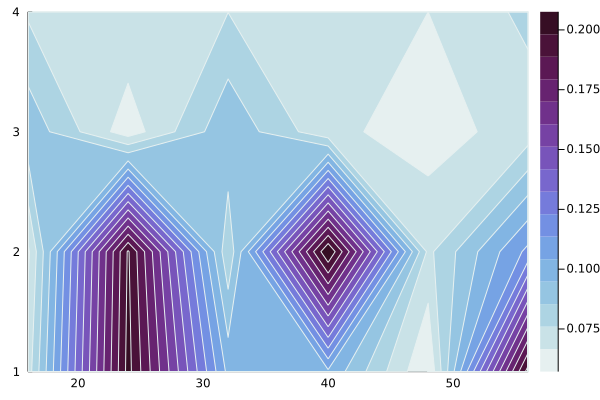

In [47]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_nonoise), c=:dense), dpi=600)

In [17]:
d_val_05noise = get_d_val(ho_05noise, dataset, "./src/examples/burgers/models/feedforward_256/tuning_burgers_05noise_reg_iter_");

64

In [31]:
d_05noise

Dict{Any, Any} with 24 entries:
  (2, 56) => 0.0130963
  (1, 24) => 0.031048
  (4, 32) => 0.0251537
  (3, 24) => 0.0321609
  (1, 48) => 0.0176072
  (2, 32) => 0.022927
  (1, 40) => 0.0194493
  (1, 16) => 0.077527
  (1, 56) => 0.0170047
  (3, 48) => 0.0151357
  (3, 40) => 0.0192996
  (4, 24) => 0.0383944
  (3, 16) => 0.0783523
  (2, 24) => 0.0306349
  (3, 56) => 0.0134308
  (1, 32) => 0.0239211
  (4, 48) => 0.0171165
  (4, 40) => 0.0213546
  (2, 48) => 0.015954
  (2, 40) => 0.0178955
  (4, 16) => 0.04
  (3, 32) => 0.0232905
  (2, 16) => 0.0773839
  (4, 56) => 0.0133271

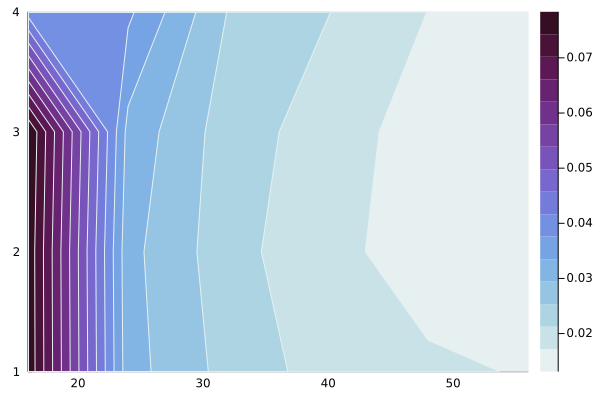

In [46]:
plot(contourf(x, y, (x, y) -> f(x, y, d_05noise), c=:dense), dpi=600)

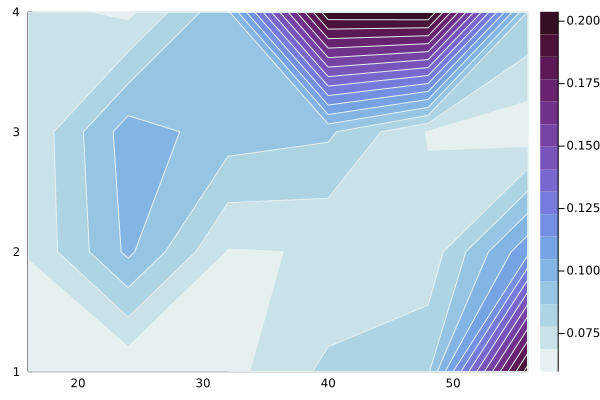

In [44]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_05noise), c=:dense), dpi=600)

In [20]:
d_val_15noise = get_d_val(ho_15noise, dataset, "./src/examples/burgers/models/feedforward_256/tuning_burgers_15noise_reg_iter_");

64

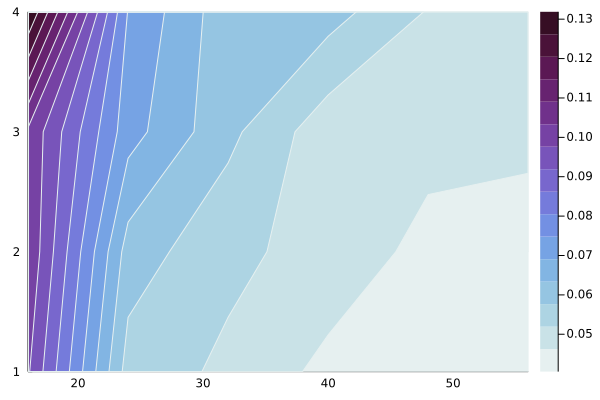

In [45]:
plot(contourf(x, y, (x, y) -> f(x, y, d_15noise), c=:dense), dpi=600)

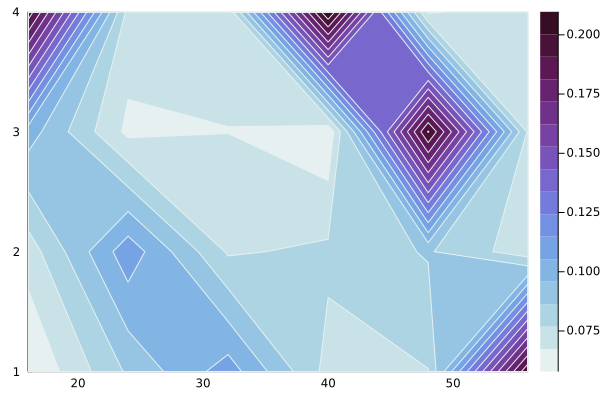

In [48]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_15noise), c=:dense), dpi=600)

## Check results

In [7]:
dataset = Generator.read_dataset("./src/examples/burgers/dataset/high_dim_1k_set.jld2")["training_set"];
(train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.75, false, false);
(x, y, z) = first(train_loader);
u0 = x[:, 10];
u = y[:, :, 10];
t = z[10];

┌ Warning: read type LinRange{Float64} is not a leaf type in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:237
Error encountered while load FileIO.File{FileIO.DataFormat{:JLD2}, String}("./src/examples/burgers/dataset/high_dim_1k_set.jld2").

Fatal error:


LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mJLD2.ReconstructedTypes.var"##LinRange{Float64}#372"[39m[0m to an object of type 
[0m  [91mAbstractArray{Float64}[39m
[0mClosest candidates are:
[0m  convert(::Type{AbstractArray{T}}, [91m::LazyBandedMatrices.BlockVcat{T, N}[39m) where {T, N} at ~/.julia/packages/LazyBandedMatrices/8pXDE/src/blockconcat.jl:43
[0m  convert(::Type{AbstractArray{T}}, [91m::LazyBandedMatrices.BlockVcat{<:Any, N}[39m) where {T, N} at ~/.julia/packages/LazyBandedMatrices/8pXDE/src/blockconcat.jl:41
[0m  convert(::Type{AbstractArray{T}}, [91m::LazyBandedMatrices.BlockBroadcastArray{T, N, typeof(hvcat)}[39m) where {T, N} at ~/.julia/packages/LazyBandedMatrices/8pXDE/src/blockconcat.jl:317
[0m  ...
Stacktrace:
  [1] [0m[1mrconvert[22m[0m[1m([22m[90mT[39m::[0mType, [90mx[39m::[0mJLD2.ReconstructedTypes.var"##LinRange[90m{Float64}#372"[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/data/[39m[90m[4mcustom_serialization.jl:10[24m[39m
  [2] [0m[1mjlconvert[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/data/[39m[90m[4mwriting_datatypes.jl:305[24m[39m[90m [inlined][39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdataio.jl:70[24m[39m[90m [inlined][39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
  [5] [0m[1mread_array![22m[0m[1m([22m[90mv[39m::[0mVector[90m{AbstractArray{Float64}}[39m, [90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mrr[39m::[0mJLD2.ReadRepresentation[90m{AbstractArray{Float64}, JLD2.RelOffset}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdataio.jl:68[24m[39m
  [6] [0m[1mread_array[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mdataspace[39m::[0mJLD2.ReadDataspace, [90mrr[39m::[0mJLD2.ReadRepresentation[90m{AbstractArray{Float64}, JLD2.RelOffset}[39m, [90mdata_length[39m::[0mInt64, [90mfilter_id[39m::[0mUInt16, [90mheader_offset[39m::[0mJLD2.RelOffset, [90mattributes[39m::[0mVector[90m{JLD2.ReadAttribute}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:329[24m[39m
  [7] [0m[1mread_data[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mrr[39m::[0mJLD2.ReadRepresentation[90m{Any, JLD2.RelOffset}[39m, [90mread_dataspace[39m::[0mTuple[90m{JLD2.ReadDataspace, JLD2.RelOffset, Int64, UInt16}[39m, [90mattributes[39m::[0mVector[90m{JLD2.ReadAttribute}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:200[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:156[24m[39m[90m [inlined][39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatatypes.jl:76[24m[39m[90m [inlined][39m
 [10] [0m[1mread_data[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mdataspace[39m::[0mJLD2.ReadDataspace, [90mdatatype_class[39m::[0mUInt8, [90mdatatype_offset[39m::[0mInt64, [90mdata_offset[39m::[0mInt64, [90mdata_length[39m::[0mInt64, [90mfilter_id[39m::[0mUInt16, [90mheader_offset[39m::[0mJLD2.RelOffset, [90mattributes[39m::[0mVector[90m{JLD2.ReadAttribute}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:152[24m[39m
 [11] [0m[1mload_dataset[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90moffset[39m::[0mJLD2.RelOffset[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:92[24m[39m
 [12] [0m[1mjlconvert[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/data/[39m[90m[4mwriting_datatypes.jl:304[24m[39m[90m [inlined][39m
 [13] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdataio.jl:70[24m[39m[90m [inlined][39m
 [14] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
 [15] [0m[1mread_array![22m[0m[1m([22m[90mv[39m::[0mVector[90m{Any}[39m, [90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mrr[39m::[0mJLD2.ReadRepresentation[90m{Any, JLD2.RelOffset}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdataio.jl:68[24m[39m
 [16] [0m[1mread_array[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mdataspace[39m::[0mJLD2.ReadDataspace, [90mrr[39m::[0mJLD2.ReadRepresentation[90m{Any, JLD2.RelOffset}[39m, [90mdata_length[39m::[0mInt64, [90mfilter_id[39m::[0mUInt16, [90mheader_offset[39m::[0mJLD2.RelOffset, [90mattributes[39m::[0mVector[90m{JLD2.ReadAttribute}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:329[24m[39m
 [17] [0m[1mread_data[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mrr[39m::[0mJLD2.ReadRepresentation[90m{Any, JLD2.RelOffset}[39m, [90mread_dataspace[39m::[0mTuple[90m{JLD2.ReadDataspace, JLD2.RelOffset, Int64, UInt16}[39m, [90mattributes[39m::[0mVector[90m{JLD2.ReadAttribute}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:200[24m[39m
 [18] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:156[24m[39m[90m [inlined][39m
 [19] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatatypes.jl:76[24m[39m[90m [inlined][39m
 [20] [0m[1mread_data[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mdataspace[39m::[0mJLD2.ReadDataspace, [90mdatatype_class[39m::[0mUInt8, [90mdatatype_offset[39m::[0mInt64, [90mdata_offset[39m::[0mInt64, [90mdata_length[39m::[0mInt64, [90mfilter_id[39m::[0mUInt16, [90mheader_offset[39m::[0mJLD2.RelOffset, [90mattributes[39m::[0mVector[90m{JLD2.ReadAttribute}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:152[24m[39m
 [21] [0m[1mload_dataset[22m[0m[1m([22m[90mf[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90moffset[39m::[0mJLD2.RelOffset[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mdatasets.jl:92[24m[39m
 [22] [0m[1mgetindex[22m[0m[1m([22m[90mg[39m::[0mJLD2.Group[90m{JLD2.JLDFile{JLD2.MmapIO}}[39m, [90mname[39m::[0mString[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mgroups.jl:109[24m[39m
 [23] [0m[1mgetindex[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mJLD2.jl:393[24m[39m[90m [inlined][39m
 [24] [0m[1mloadtodict![22m[0m[1m([22m[90md[39m::[0mDict[90m{String, Any}[39m, [90mg[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m, [90mprefix[39m::[0mString[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mloadsave.jl:154[24m[39m
 [25] [0m[1mloadtodict![22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mloadsave.jl:153[24m[39m[90m [inlined][39m
 [26] [0m[1m(::JLD2.var"#72#73")[22m[0m[1m([22m[90mfile[39m::[0mJLD2.JLDFile[90m{JLD2.MmapIO}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mfileio.jl:39[24m[39m
 [27] [0m[1mjldopen[22m[0m[1m([22m::[0mFunction, ::[0mString, ::[0mVararg[90m{String}[39m; [90mkws[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mloadsave.jl:4[24m[39m
 [28] [0m[1mjldopen[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mloadsave.jl:2[24m[39m[90m [inlined][39m
 [29] [0m[1m#fileio_load#71[22m
[90m    @ [39m[90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mfileio.jl:38[24m[39m[90m [inlined][39m
 [30] [0m[1mfileio_load[22m[0m[1m([22m[90mf[39m::[0mFileIO.File[90m{FileIO.DataFormat{:JLD2}, String}[39m[0m[1m)[22m
[90m    @ [39m[35mJLD2[39m [90m~/.julia/packages/JLD2/k9Gt0/src/[39m[90m[4mfileio.jl:38[24m[39m
 [31] [0m[1m#invokelatest#2[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:716[24m[39m[90m [inlined][39m
 [32] [0m[1minvokelatest[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:714[24m[39m[90m [inlined][39m
 [33] [0m[1maction[22m[0m[1m([22m::[0mSymbol, ::[0mVector[90m{Union{Base.PkgId, Module}}[39m, ::[0mFileIO.Formatted; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/Nl9Lh/src/[39m[90m[4mloadsave.jl:219[24m[39m
 [34] [0m[1maction[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/Nl9Lh/src/[39m[90m[4mloadsave.jl:197[24m[39m[90m [inlined][39m
 [35] [0m[1maction[22m[0m[1m([22m::[0mSymbol, ::[0mVector[90m{Union{Base.PkgId, Module}}[39m, ::[0mSymbol, ::[0mString; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/Nl9Lh/src/[39m[90m[4mloadsave.jl:185[24m[39m
 [36] [0m[1maction[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/Nl9Lh/src/[39m[90m[4mloadsave.jl:185[24m[39m[90m [inlined][39m
 [37] [0m[1mload[22m[0m[1m([22m::[0mString; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[36mFileIO[39m [90m~/.julia/packages/FileIO/Nl9Lh/src/[39m[90m[4mloadsave.jl:113[24m[39m
 [38] [0m[1mload[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/Nl9Lh/src/[39m[90m[4mloadsave.jl:110[24m[39m[90m [inlined][39m
 [39] [0m[1mread_dataset[22m[0m[1m([22m[90mfilepath[39m::[0mString[0m[1m)[22m
[90m    @ [39m[32mMain.Generator[39m [90m~/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/utils/[39m[90m[4mgenerators.jl:215[24m[39m
 [40] top-level scope
[90m    @ [39m[90m[4mIn[7]:1[24m[39m

In [77]:
filename = "./src/examples/burgers/models/high_dim_1k_model_j173.bson"
# filename = "./src/examples/burgers/models/feedforward_256/tuning_burgers_05noise_reg_iter_21.bson"
@load filename K p

In [80]:
K

Chain(
  Dense(64 => 48, tanh),                # 3_120 parameters
  Dense(48 => 48, tanh),                # 2_352 parameters
  Dense(48 => 48, tanh),                # 2_352 parameters
  Dense(48 => 48, tanh),                # 2_352 parameters
  Dense(48 => 64),                      # 3_136 parameters
)                   # Total: 10 arrays, 13_312 parameters, 52.625 KiB.

In [133]:
t, u0, u = Generator.get_burgers_batch(1., 0., pi, 0., 64, 64, 0.03, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), abstol=1e-9, reltol=1e-9, saveat=t);
u_pred = prob_neuralode(u0, p);

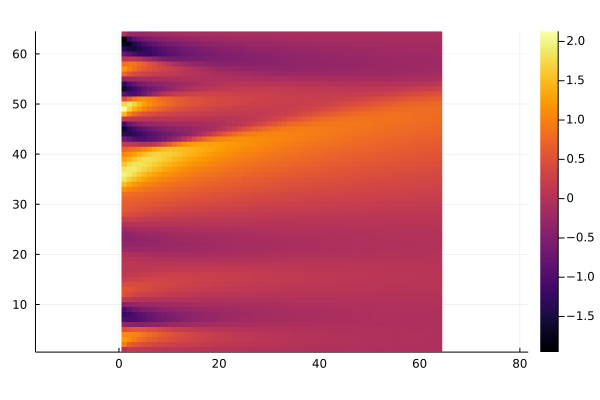

In [134]:
GraphicTools.show_state(u, "")

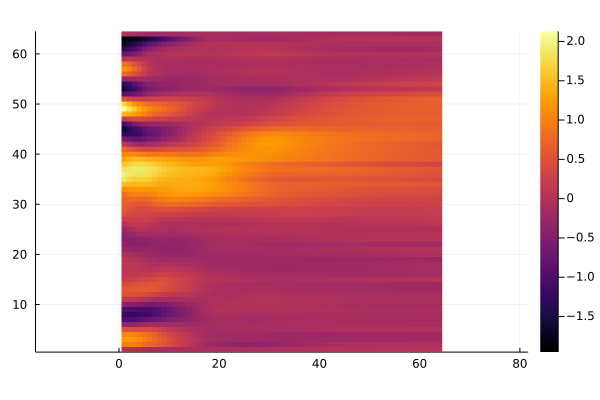

In [135]:
GraphicTools.show_state(hcat(u_pred.u...), "")

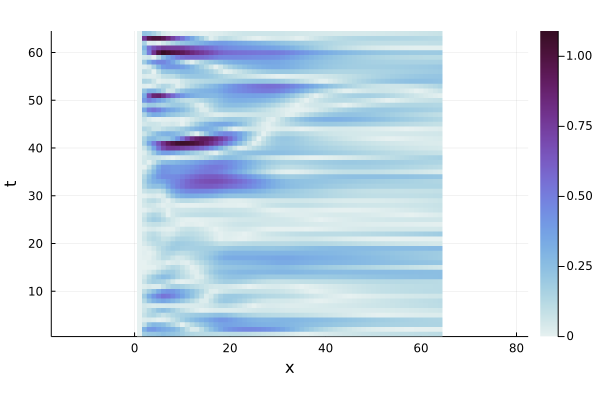

In [136]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

In [31]:
using Statistics
t_n = 64
function plot_mse_snapshot(ŷ, y, t)
    function e(ŷ, y)
        mean((ŷ .- y) .^ 2)
    end

    mse = []
    for i ∈ 1:t_n
        push!(mse, e(u_pred[:, i], u[:, i]))
    end

    plt = plot(mse, linestyle=:dash, label="t0")
end

plot_mse_snapshot (generic function with 1 method)

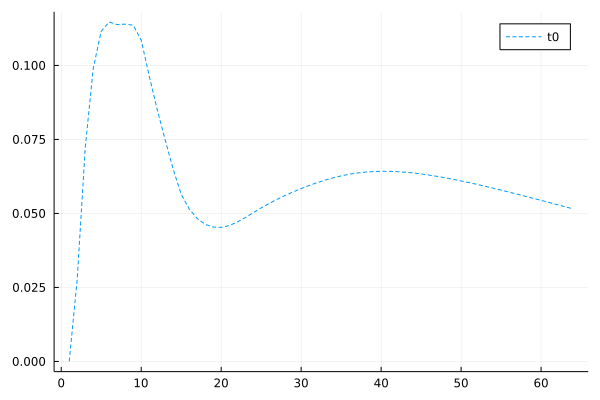

In [32]:
plot_mse_snapshot(u_pred, u, collect(LinRange(0., 1., 64)))

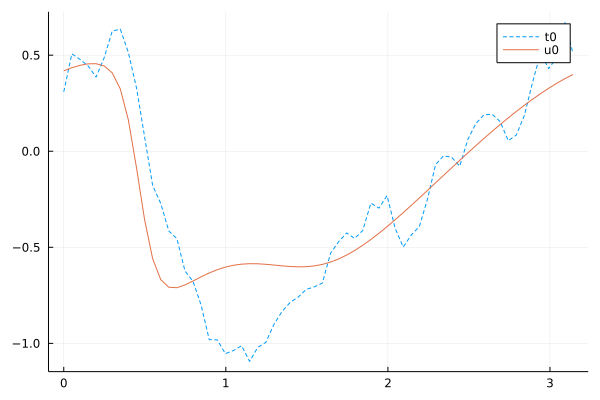

In [33]:
x = collect(LinRange(0., pi, 64));
plt = plot(x, u_pred[:, end], linestyle=:dash, label="t0")
plot!(plt, x, u[:, end], label="u0")

┌ Info: Saved animation to 
│   fn = /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_viscous_burgers_nu004_fps15.gif
└ @ Plots /Users/vdesgrange/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_viscous_burgers_nu004_fps15.gif")
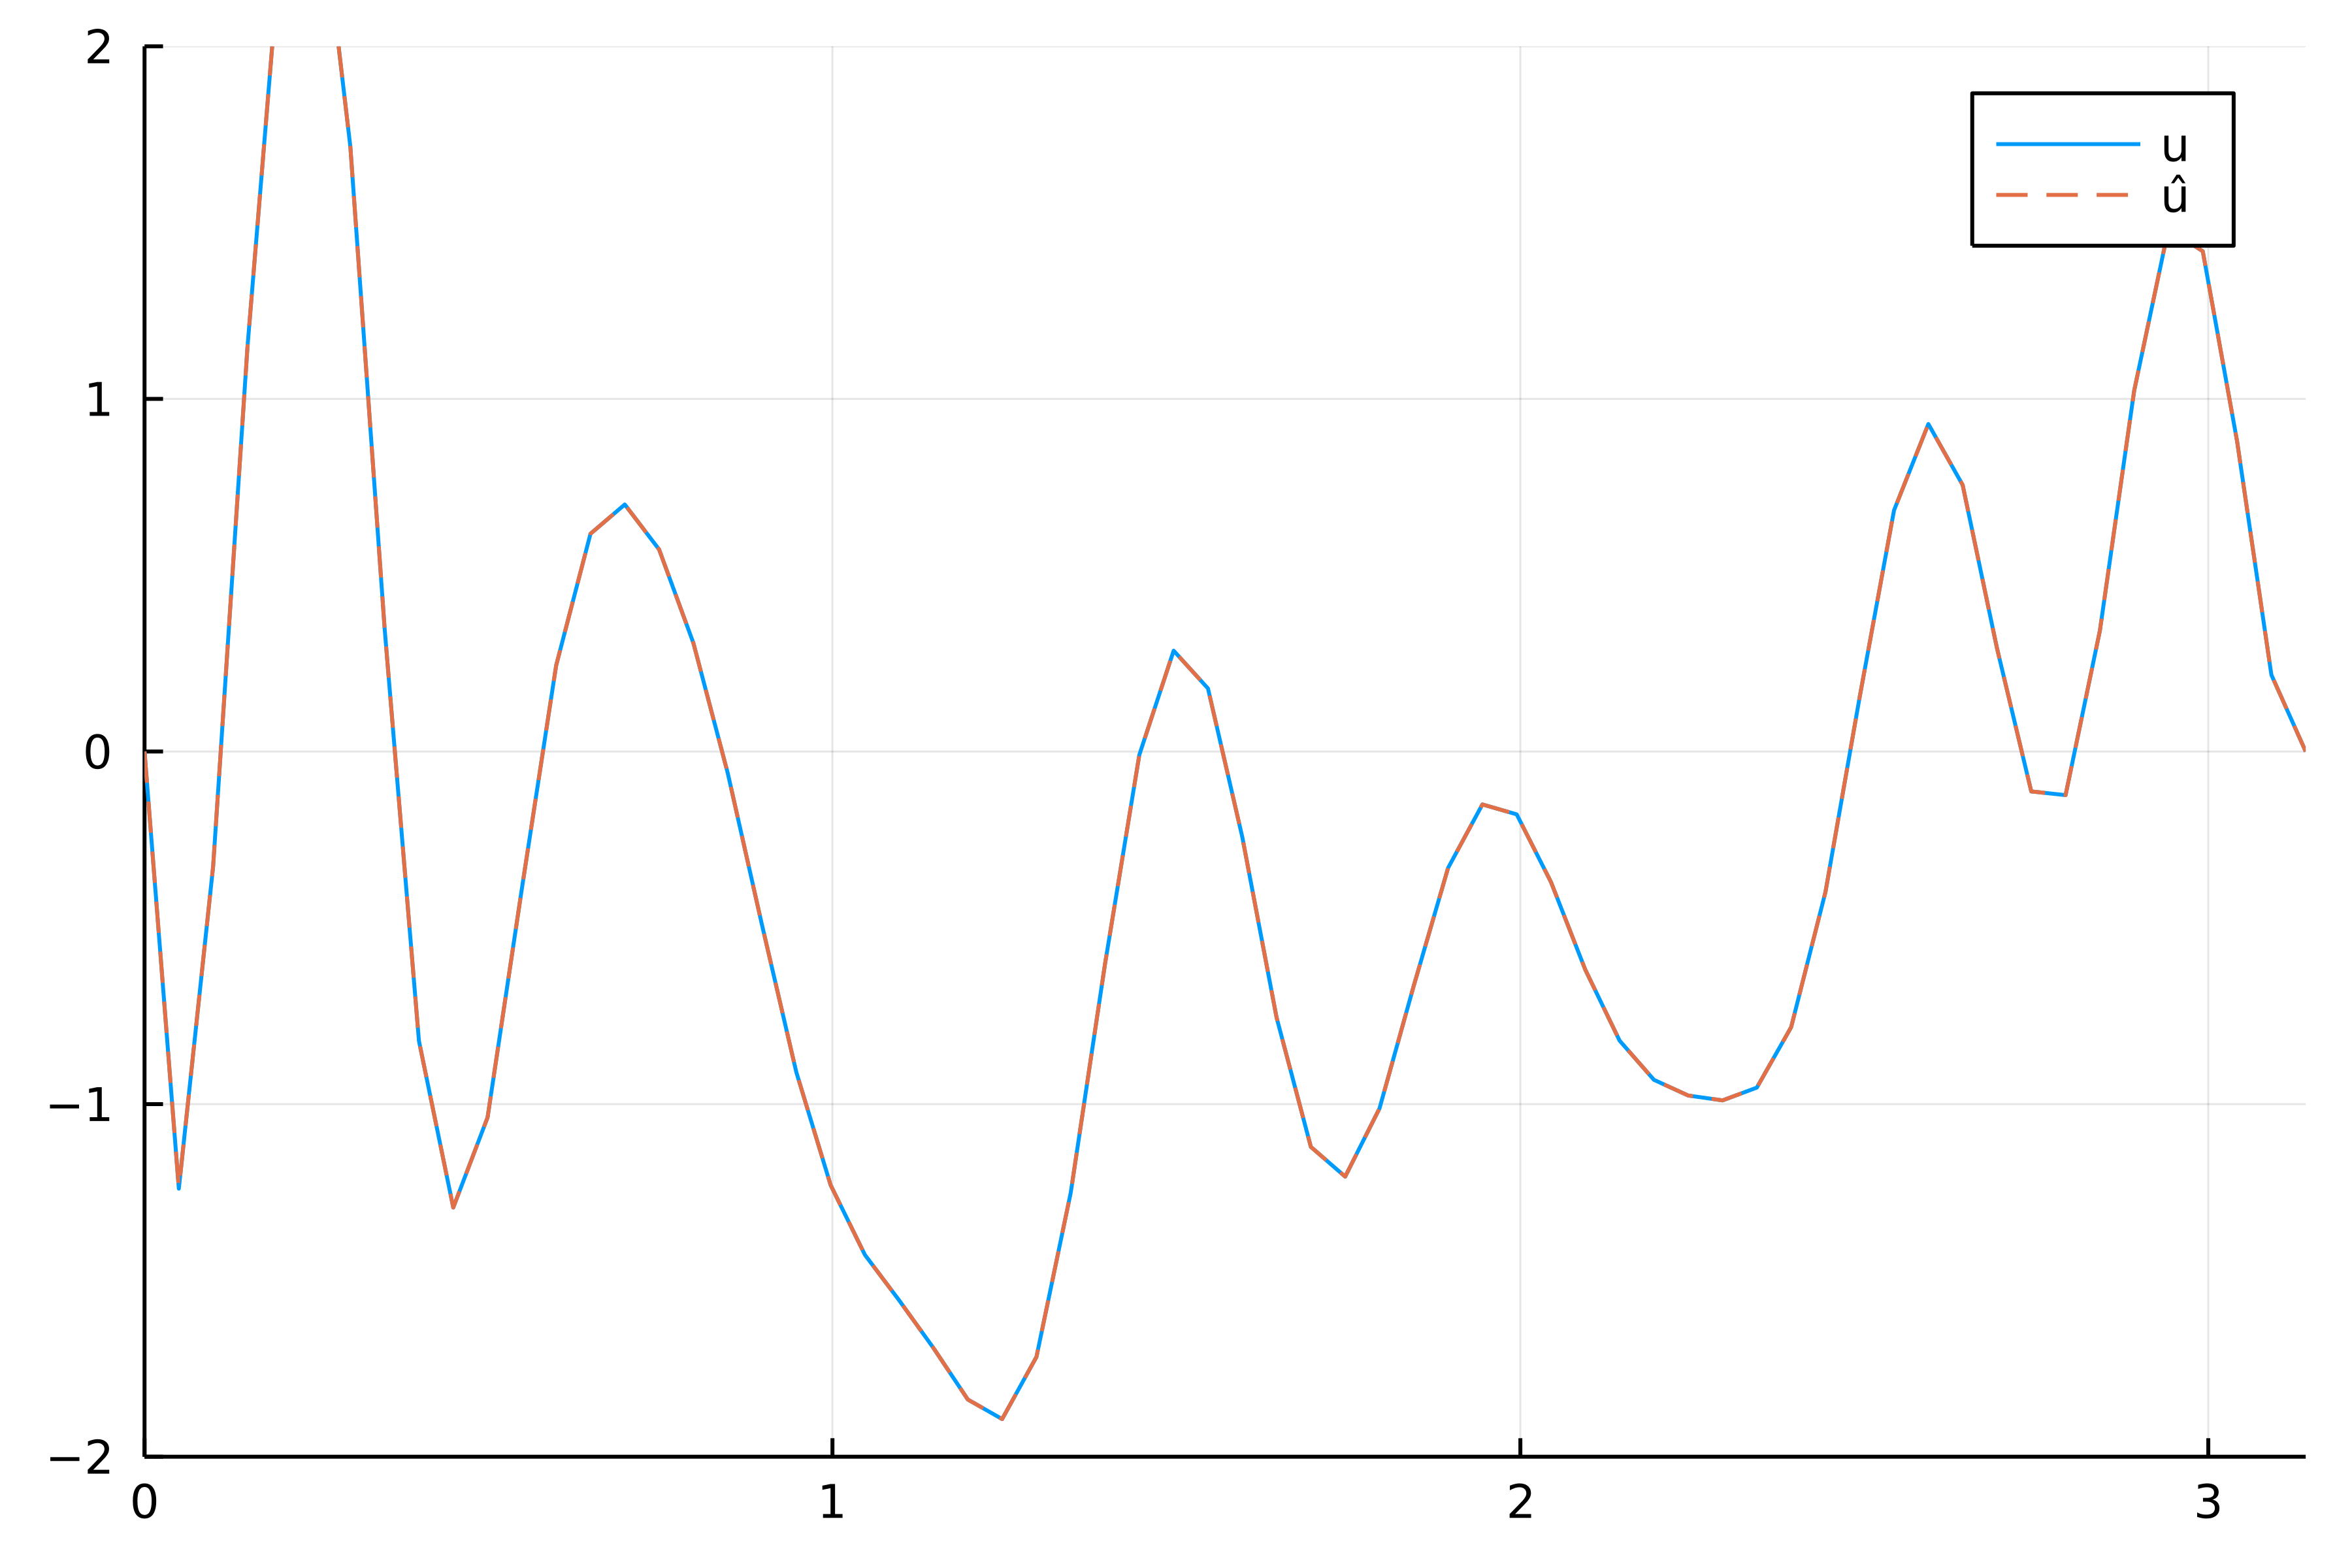

In [34]:
function animate_snapshot_prediction(u_pred, u, x, filename)
    t_n = 64
   
    anim = @animate for i ∈ 1:t_n
        plt = plot(x, u[:, i], label="u")
        plot!(plt, x, u_pred[:, i], linestyle=:dash, label="û")
        plot!(plt; xlims=(0., pi), ylims=(-2, 2.), dpi=600)
    end

    gif(anim, filename, fps = 15)
end

animate_snapshot_prediction(u_pred, u, collect(LinRange(0., pi, 64)), "snapshot_viscous_burgers_nu004_fps15.gif")

## Tuning - Regularization

Check the training and validation cost function after training neural network for different $L_2$ regularization parameters. Consider case with Gaussian noise added to prediction.

In [2]:
ho = JLD2.load("./src/examples/burgers/models/feedforward4/hyperopt_result_fnn.jld2")["ho"];

┌ Warning: type Hyperopt.RandomSampler{Random.MersenneTwister} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{JLD2.ReconstructedTypes.var"##Hyperopt.RandomSampler{Random.MersenneTwister}#334",Main.#1744###hyperopt_objective#411#18} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461


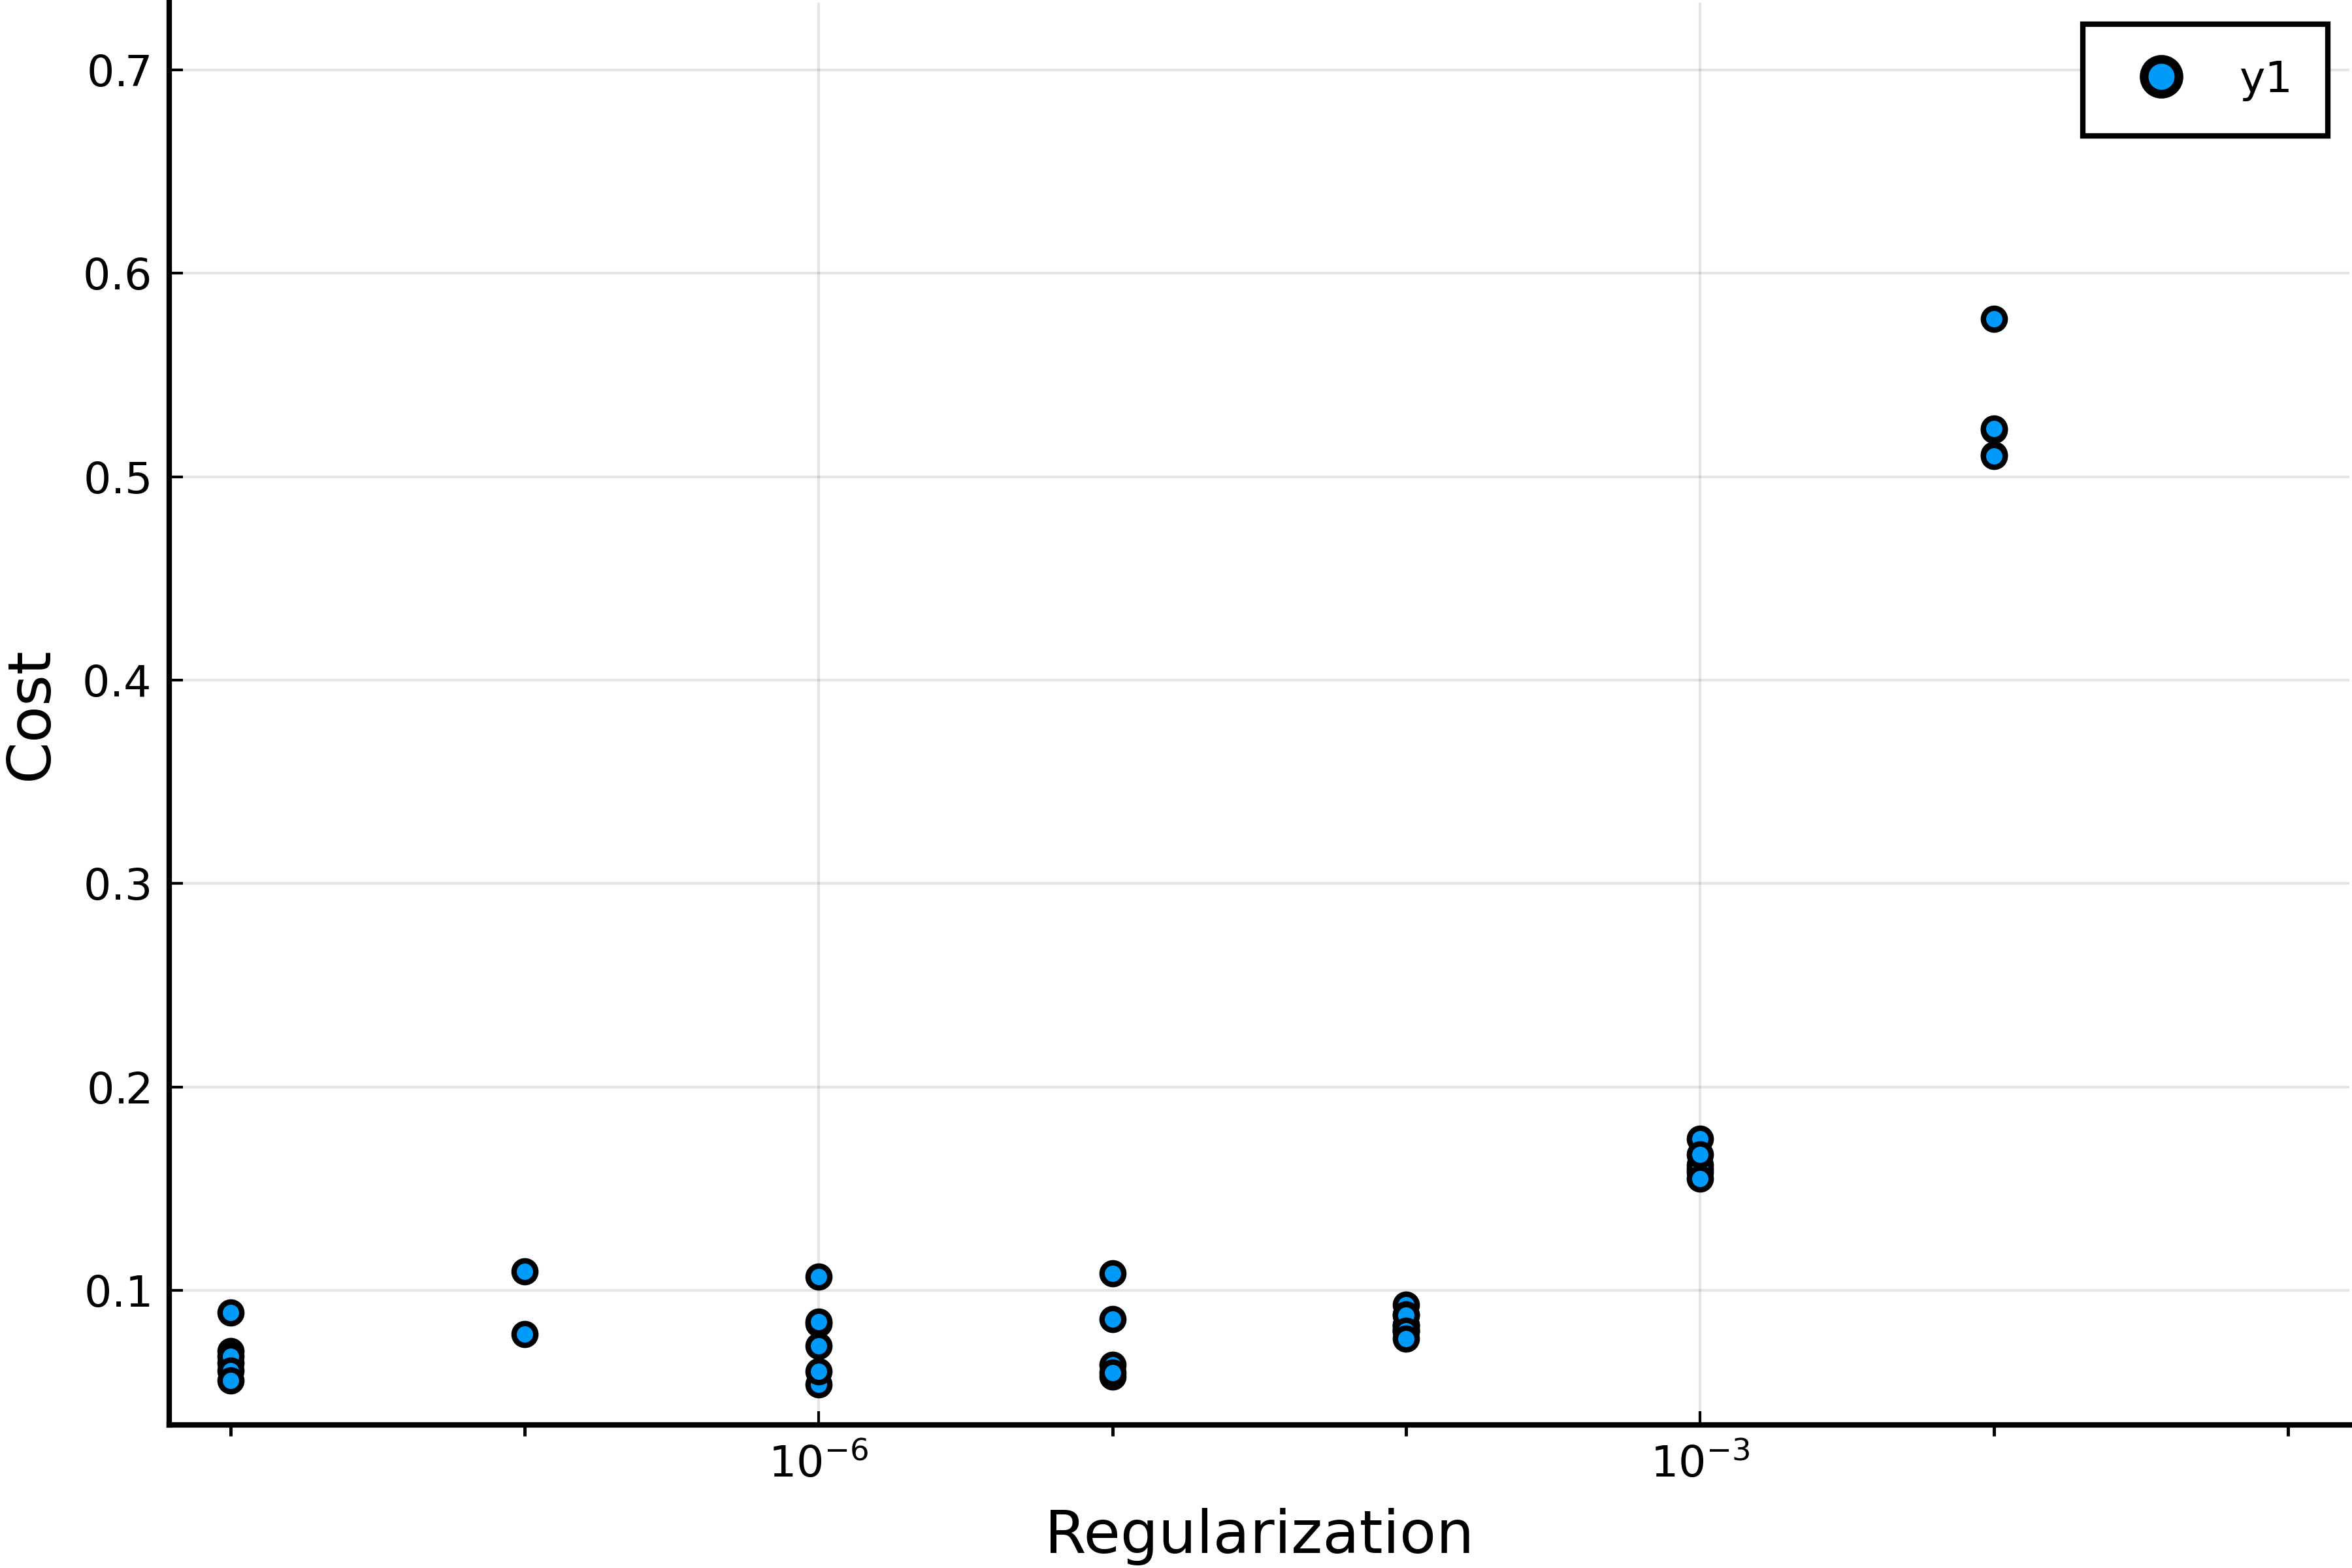

In [20]:
ho.history;

function get_reg(ho)
    x = [];
    y = [];

    for (i, tupl) in enumerate(ho.history)
        push!(x, tupl[3]);
        push!(y, ho.results[i]);
    end
    
    return x, y
end

using BSON

function get_reg_val(ho, dataset, filepath)
    x = [];
    y = [];
    
    (_, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.7, false, false);
    
    function val_loss(K, p, x, y, t)
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
        ŷ = prob_neuralode(x, p);
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
        return l;
    end
    
    function evalcb(K, p, val_loader)
        lval = 0;
        for (x, y, t) in val_loader
            lval += val_loss(K, p, x, y, t[1]);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        return lval
    end
    
    for (i, tupl) in enumerate(ho.history)
        filename = filepath * string(i) * ".bson"
        BSON.@load filename K p;
        lval = evalcb(K, p, val_loader);

        push!(x, tupl[3]);
        push!(y, lval);
    end
    
    return x, y
end

x, y = get_reg(ho);
plt = scatter(x, y)
scatter!(plt; dpi=600, xaxis=:log, xlabel="Regularization", ylabel="Cost")


# print(d)

---
### Training 

In [42]:
function main()
  batch_size = 32;
  epochs = 100;
  hl = 3;
  ne = 48;
  reg = 1.0e-7;
  noi = 0.05
  ratio = 0.75;
  lr = 0.03;

  data = Generator.read_dataset("./src/examples/burgers/dataset/high_dim_256_set_j173.jld2")["training_set"];
  model = Models.CAE(64, 2, 3);
  K, p = BurgersDirect.training(model, epochs, data, batch_size, ratio, lr, noi, reg, false);
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:24
┌ Info: Loading dataset
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:31
┌ Info: Building model
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:34
┌ Info: Initiate training
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:81
┌ Info: Epoch 1
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


LoadError: DimensionMismatch("Rank of x and w must match! (2 vs. 4)")

In [44]:
(train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.75, false, false);

In [53]:
for (x, y, t) in train_loader
      # (x, y, t) = (x, y, t) |> device;
    print(size(x))
end

(64, 32)(64, 32)(64, 32)(64, 32)(64, 32)(64, 32)

In [122]:
t, u0, u = Generator.get_burgers_batch(1.0, 0., pi, 0., 64, 64, 0.04, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), abstol=1e-9, reltol=1e-9, saveat=t);
u_pred = prob_neuralode(u0, p);

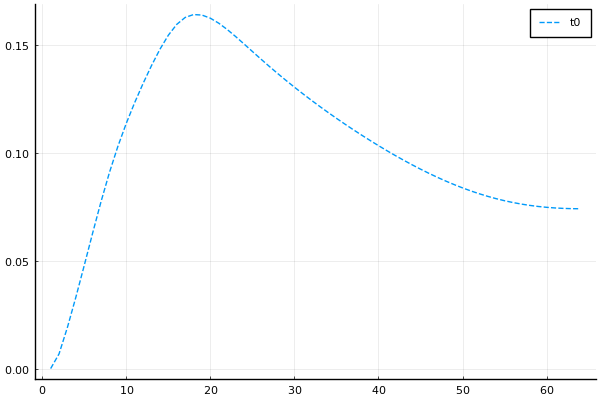

In [123]:
plot_mse_snapshot(u_pred, u, collect(LinRange(0., 0.5, 64)))

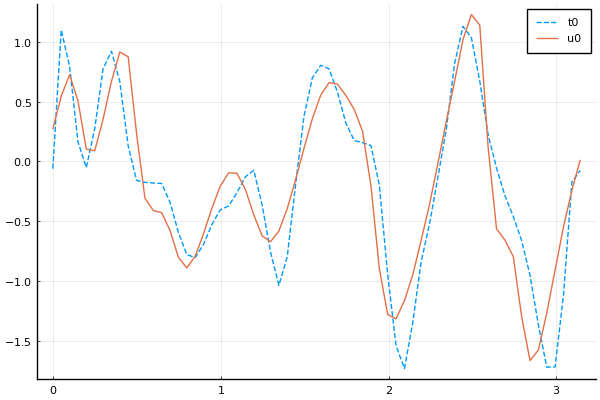

In [124]:
x = collect(LinRange(0., pi, 64));
plt = plot(x, u_pred[:, 10], linestyle=:dash, label="t0")
plot!(plt, x, u[:, 10], label="u0")

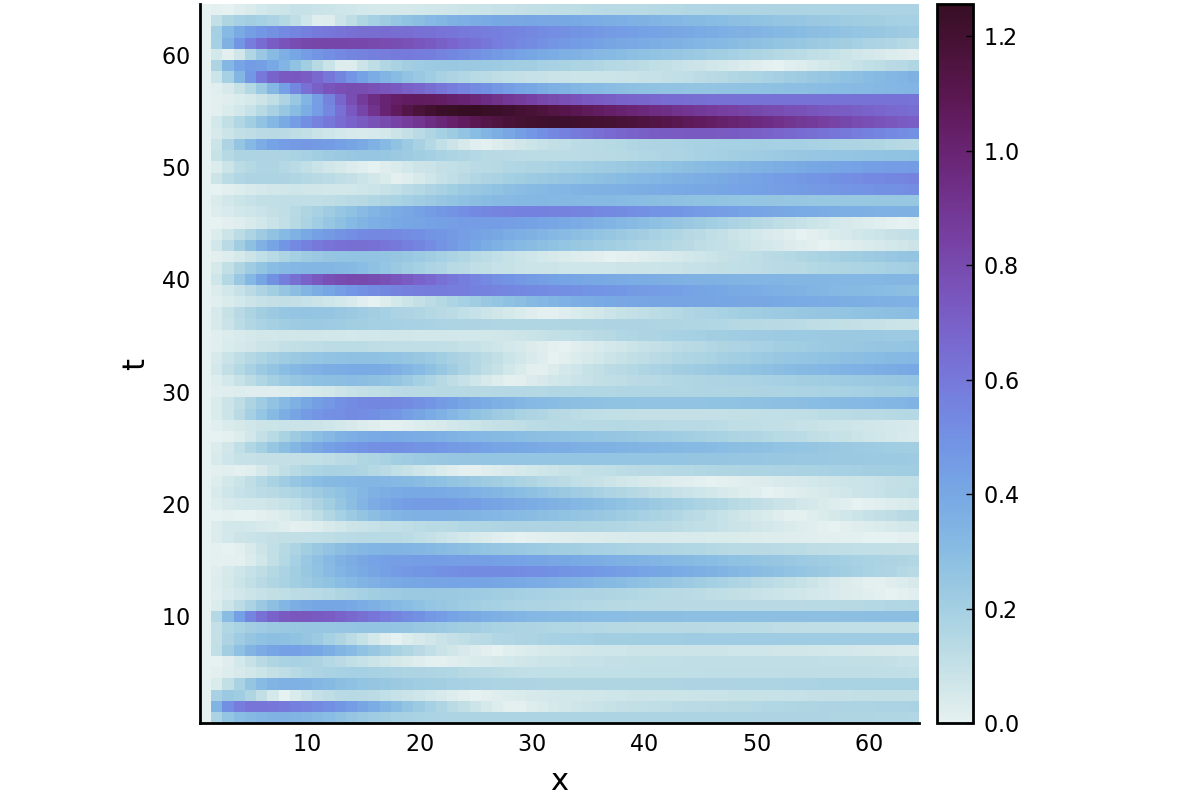

In [125]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

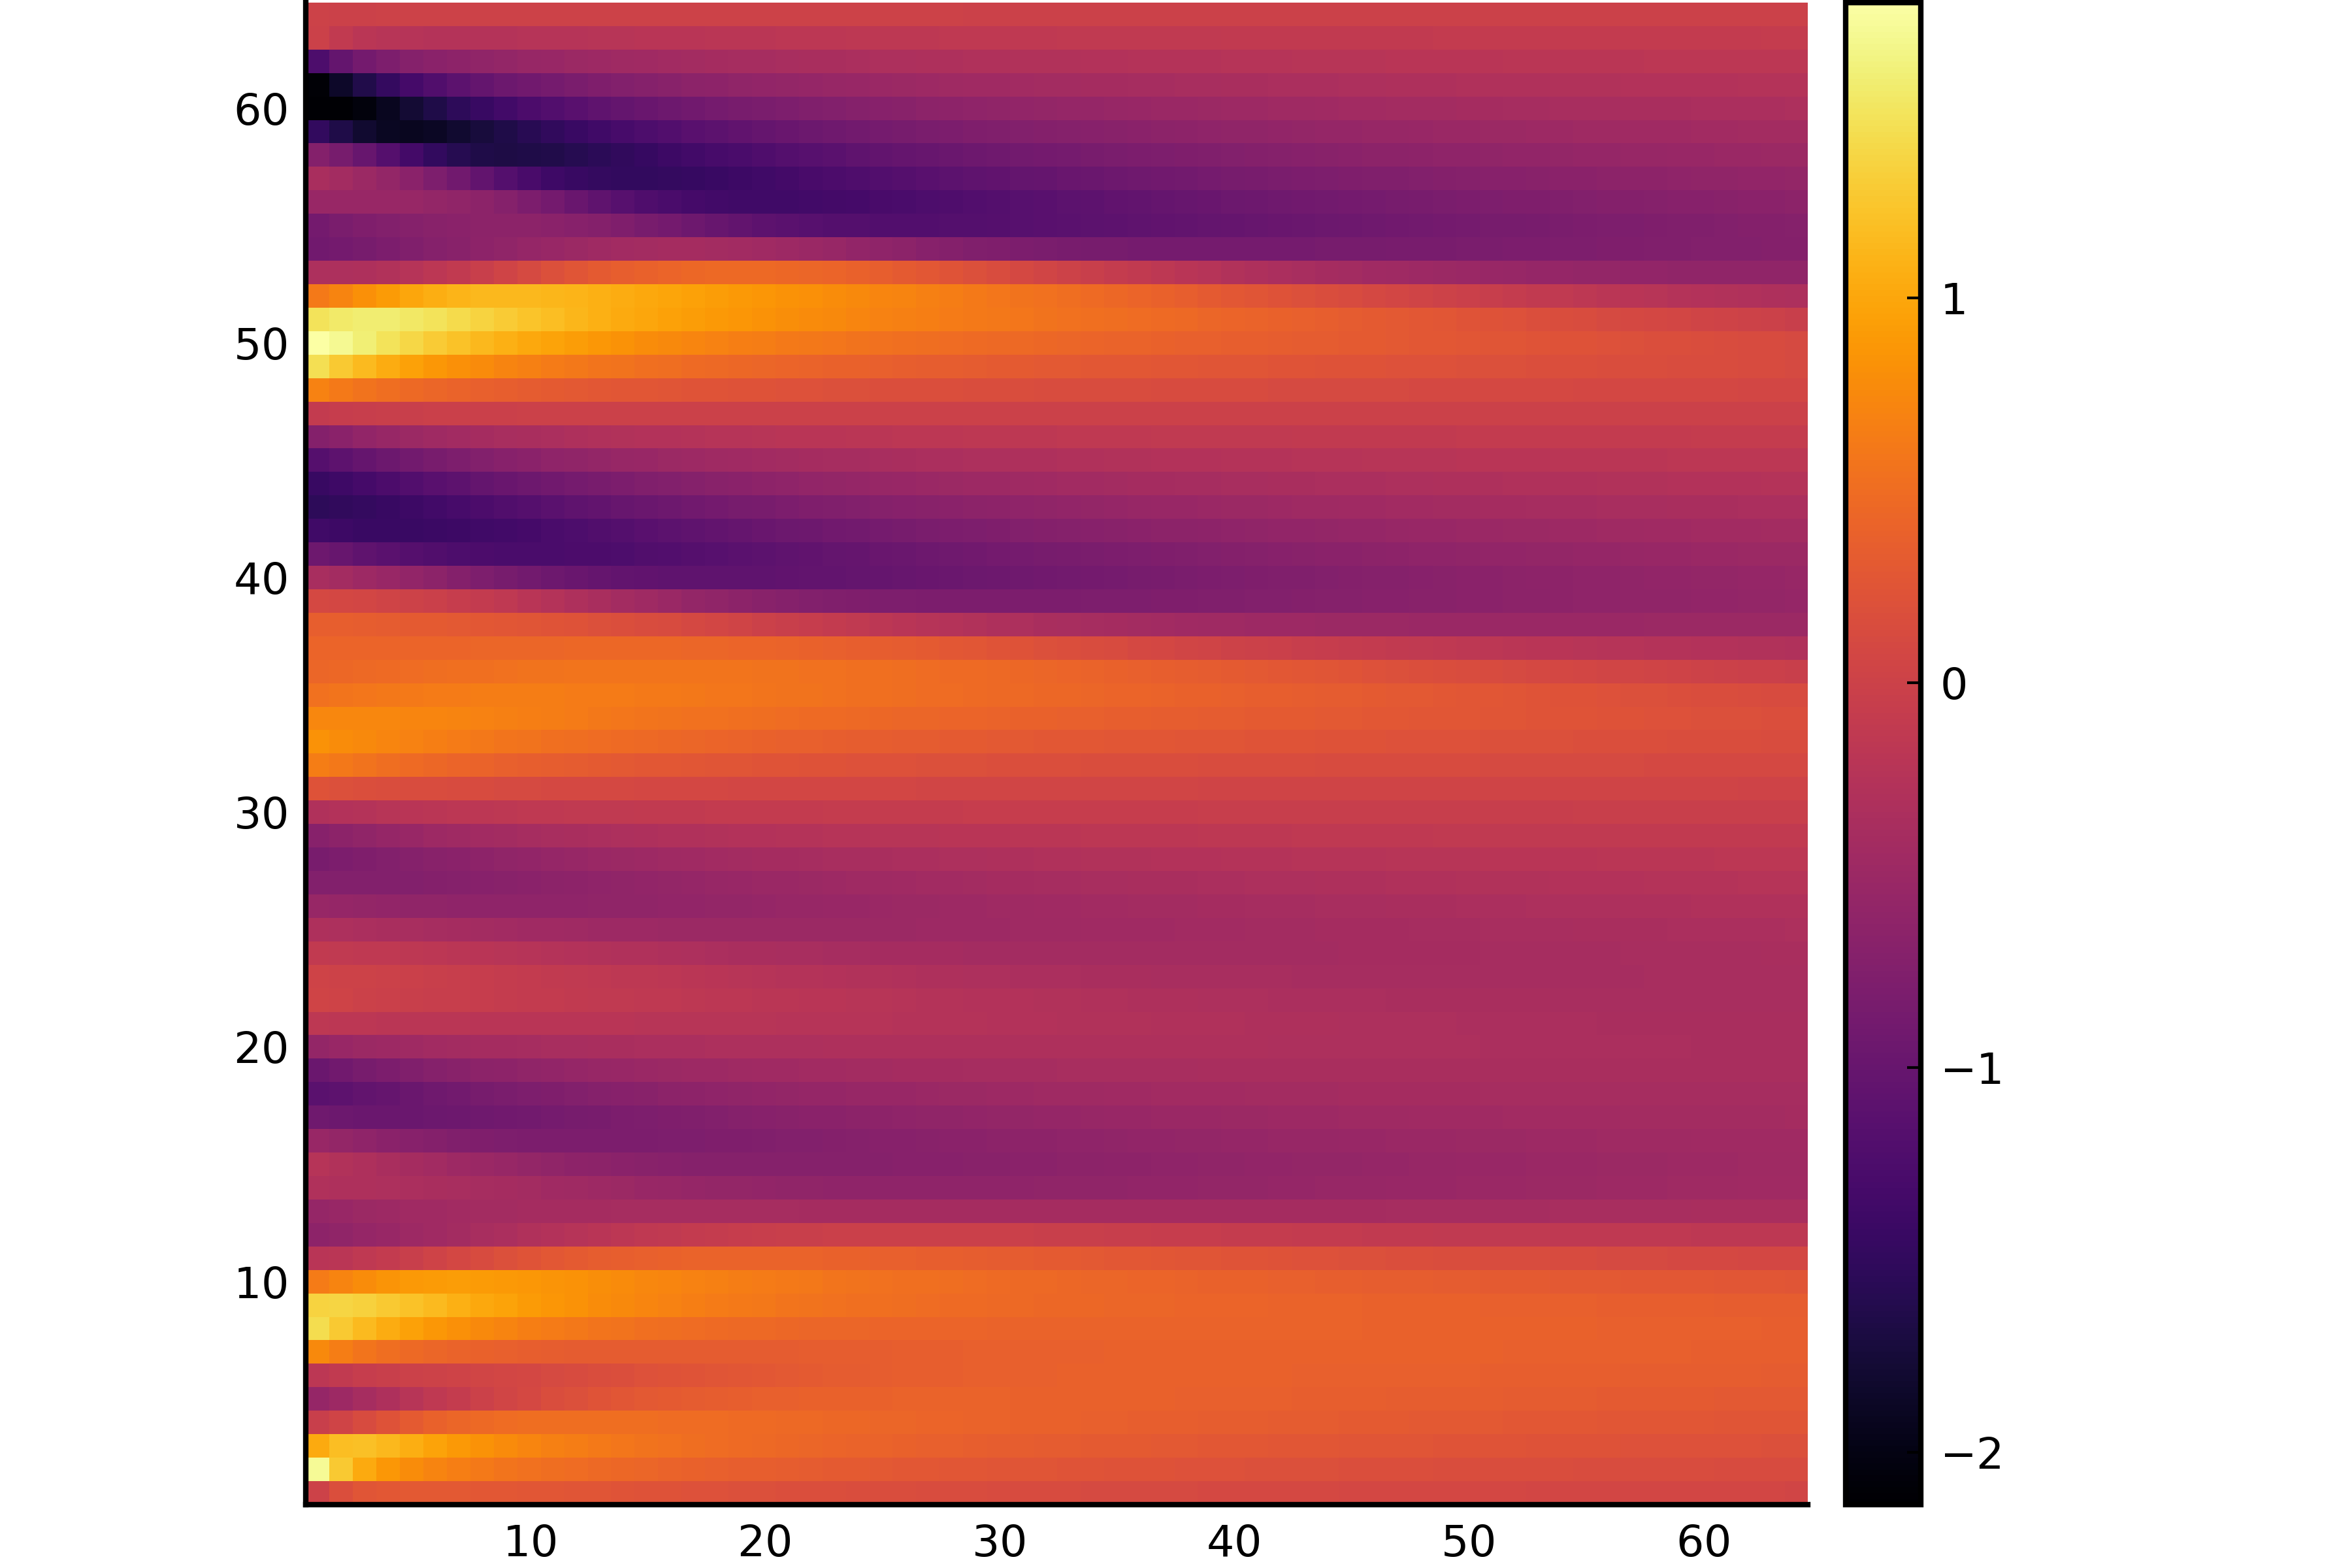

In [126]:
GraphicTools.show_state(u, "")

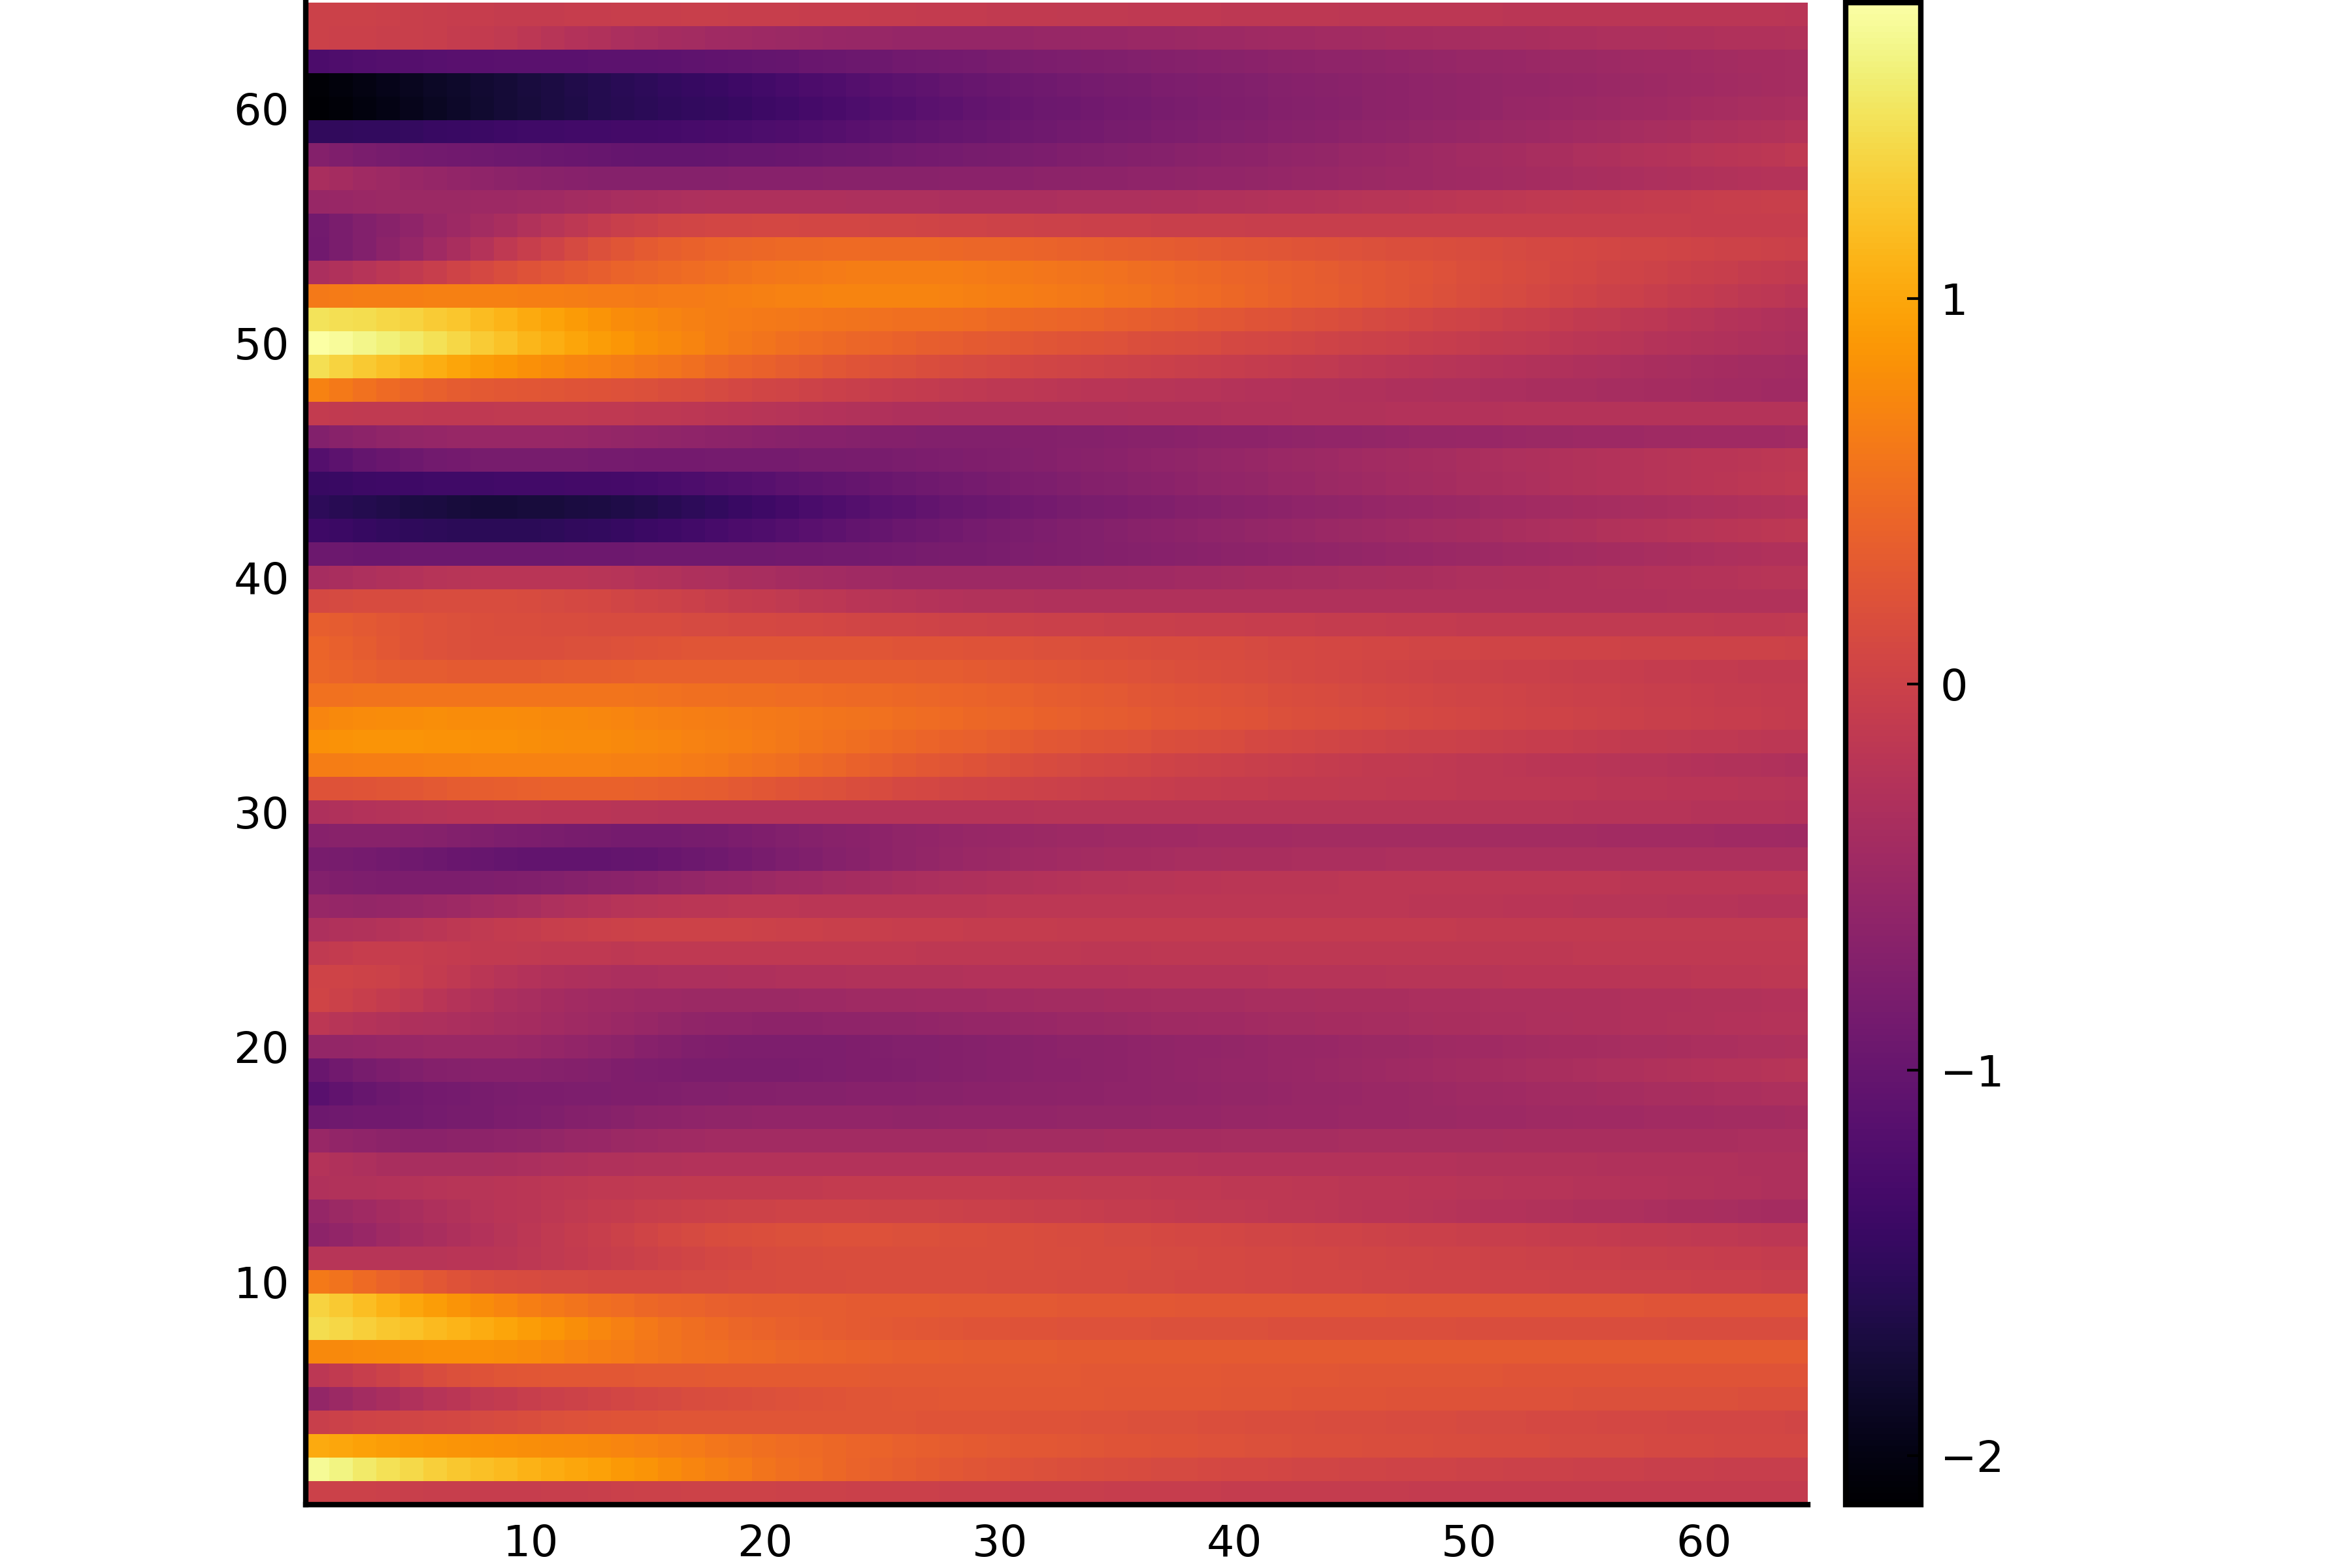

In [127]:
GraphicTools.show_state(hcat(u_pred.u...), "")